In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jupyter_helpers import *
from helpers import *

set_seed(99, True)

In [3]:
bs = 64

# arch = 'resnet18'
arch = 'levit_256'
# arch = 'levit_384'

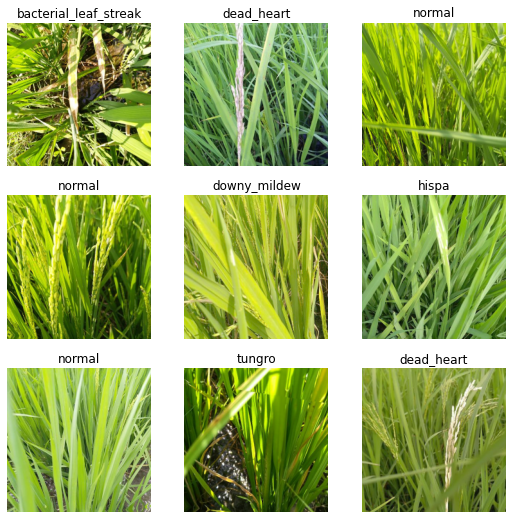

In [4]:
dls = get_image_dls(bs)
dls.show_batch()

In [5]:
learn = vision_learner(dls, arch, metrics=[accuracy], cbs=[ShowGraphCallback()])

/usr/local/lib/python3.9/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Downloading: "https://dl.fbaipublicfiles.com/LeViT/LeViT-256-13b5763e.pth" to /root/.cache/torch/hub/checkpoints/LeViT-256-13b5763e.pth


Steep: 0.009120108559727669; Valley: 0.004365158267319202; lr: 0.008208097703754903


epoch,train_loss,valid_loss,accuracy,time
0,1.779772,1.679427,0.639596,00:25


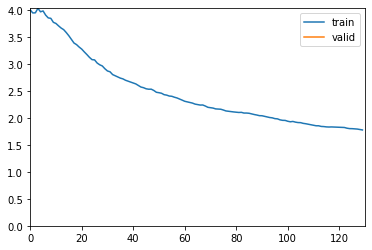

epoch,train_loss,valid_loss,accuracy,time
0,1.672946,1.512298,0.498318,00:29
1,1.191898,0.910712,0.711197,00:28
2,0.886510,0.640986,0.803460,00:29


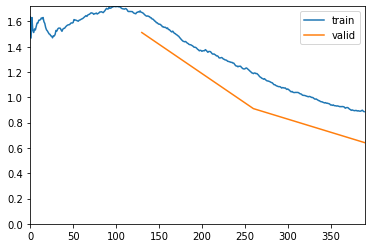

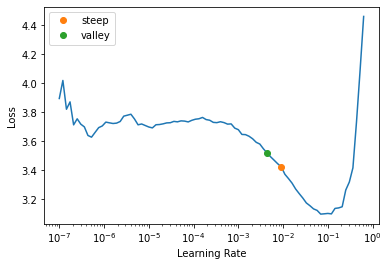

In [11]:
lr_multiplier = 0.9

with safely_train_with_gpu():
    learn.model.to(device)
    
    lr_steep, lr_valley = learn.lr_find(suggest_funcs=(steep, valley))
    lr = lr_steep * lr_multiplier
    print(f"Steep: {lr_steep}; Valley: {lr_valley}; lr: {lr}")

    learn.freeze_to(-1)
    learn.fit_one_cycle(1, lr)

    learn.unfreeze()
    learn.fit_one_cycle(3, lr / 2)

# Get embeddings

In [12]:
preds, targs = learn.get_preds()

In [13]:
preds.shape, targs.shape

(torch.Size([2081, 10]), torch.Size([2081]))

In [14]:
import matplotlib.cm as cm

def plot_scatter(df):
    colors = cm.rainbow(np.linspace(0, 1, len(df.target.unique())))
    fig, ax = plt.subplots()
    for targ in df.target.unique():
        curr_df = df[df.target == targ]
        ax.scatter(curr_df.comp1, curr_df.comp2, color=colors[targ], label=dls.vocab[targ])
    ax.legend(loc="lower right")
    plt.show()

# PCA

In [15]:
from sklearn.decomposition import PCA

In [16]:
pca = PCA(n_components=2)
comps = pca.fit_transform(preds)
df = pd.DataFrame(data=comps, columns=['comp1', 'comp2'])
df['target'] = targs
df.head()

,comp1,comp2,target
0,0.751518,-0.503993,5
1,0.031466,0.159439,9
2,-0.148831,0.143224,3
3,-0.162233,0.055349,6
4,-0.136854,0.166049,7


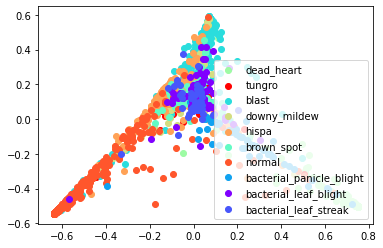

In [17]:
plot_scatter(df)

# tSNE

In [18]:
from sklearn.manifold import TSNE

In [19]:
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3)
X_embedded = tsne.fit_transform(preds)
X_embedded.shape

(2081, 2)

In [20]:
df = pd.DataFrame(data=X_embedded, columns=['comp1', 'comp2'])
df['target'] = targs
df.head()

,comp1,comp2,target
0,59.038860,78.951866,5
1,20.601305,47.119160,9
2,-75.639702,8.994018,3
3,-49.009674,-0.774973,6
4,-32.357372,-68.597687,7


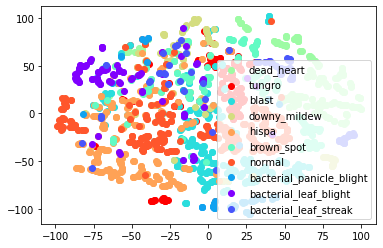

In [21]:
plot_scatter(df)